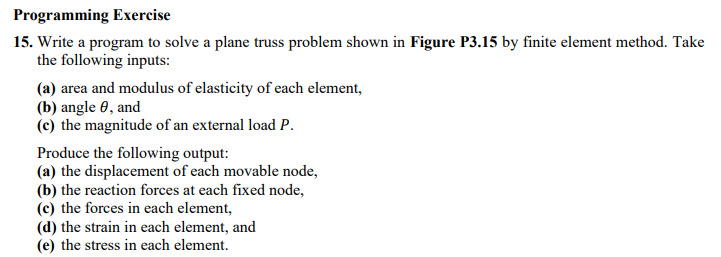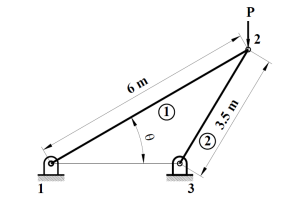

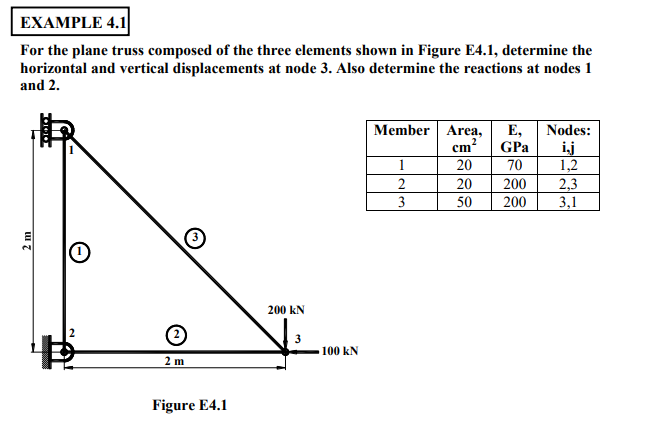

In [2]:
n_nodes = 3
area = [20,20,50]
modulus_elasticity = [70, 200, 200]
material_stiffness = [None, None, None, None]
theta = [-90, 0,135]
length = [2, 2, 2.8284]
elements = 3
element_connection = {1:[1,2], 2:[2,3], 3:[1,3]}
load_status = {3:[-100,-200]}
node_status = {1:[0,0], 2:[0,0], 3:[1,1]}

In [14]:
import numpy as np
def element_stiffness_2D(theta, modulus_elasticity = None, length = None, area = None, material_stiffness= None):
    # stiffness = np.zeros((4,4),dtype = 'int')

    stiffness_factor = material_stiffness if material_stiffness is not None else (modulus_elasticity * area/length)
    
    C = np.round(np.cos(np.radians(theta)),2)
    S = np.round(np.sin(np.radians(theta)),2)
    print(f'theta: {theta}')
    print(f'Cosine: {C}')
    print(f'Sine: {S}')
    print(f'Stiffness Factor: {stiffness_factor}')
    # print("_______________")
    # print(modulus_elasticity)
    # print(length)
    # print(area)
    # print(theta)
    stiffness = stiffness_factor*np.array([[C*C, C*S, -C*C, -C*S],
                                                           [C*S, S*S, -C*S, -S*S],
                                                           [-C*C, -C*S, C*C, C*S],
                                                           [-C*S, -S*S, C*S, S*S]
                                                           ])
    # print('here')
    # print(stiffness)
    return stiffness


def global_stiffness_matrix_2D(stiffness_list, n_nodes, element_connection):
    global_stiffness = np.zeros((n_nodes*2, n_nodes*2), dtype = 'float')
    for n,stiffness in enumerate(stiffness_list):
        # print(stiffness)
        active_element = n+1
        i, j = element_connection[active_element]
        i = i*2-2
        j = j*2-2
        # print(i)
        # print(j)
        # print("Global stiffness subarrays:")
        # print("Left (i:i+2, i:i+2):\n", global_stiffness[i:i+2, i:i+2])
        # print("Right (j:j+2, j:j+2):\n", global_stiffness[j:j+2, j:j+2])

        # # Stiffness matrix slices to be added/subtracted
        # print("\nStiffness matrix slices:")
        # print("Left (0:2, 0:2):\n", stiffness[0:2, 0:2])
        # print("Right (2:, 2:):\n", stiffness[2:, 2:])
        
        # print("Global stiffness subarrays:")
        # print("Left (i:i+2, i:i+2):\n", global_stiffness[i+2:i+4, j+2:j+4])
        # print("Right (j:j+2, j:j+2):\n", global_stiffness[j+2:j+4, i+2:j+4])

        # # Stiffness matrix slices to be added/subtracted
        # print("\nStiffness matrix slices:")
        # print("Left (0:2, 2:):\n", stiffness[0:2, 2:])
        # print("Right (2:, 0:2):\n", stiffness[2:, 0:2])

        global_stiffness[i:i+2, i:i+2] += stiffness[0:2, 0:2]
        # print(global_stiffness)
        global_stiffness[j:j+2, j:j+2] += stiffness[2:,2:]
        # print(global_stiffness)
        global_stiffness[i:i+2, j:j+2] += stiffness[0:2, 2:]
        # print(global_stiffness)
        global_stiffness[j:j+2, i:i+2] += stiffness[2:,0:2]
        # print(global_stiffness)
    # print(global_stiffness)
    return global_stiffness
        
        
def vectors_2D(n_nodes, node_status, load_status):
    load_vec = np.zeros((n_nodes*2,1), dtype = 'float')
    fixed_node_pos = []
    flexible_node_pos = []
    for node,status in node_status.items():
        i = node*2-2
        if(not status[0]):
            fixed_node_pos.append(i)
        else:
            flexible_node_pos.append(i)
        if(not status[1]):
            fixed_node_pos.append(i+1)
        else:
            flexible_node_pos.append(i+1)
    for node, load in load_status.items():
        i = node*2-2
        load_vec[i], load_vec[i+1] = load
    
    return [fixed_node_pos, flexible_node_pos, load_vec]
        

def sub_matrix(matrix, pos):
    """
    Extracts a sub-matrix from a given matrix based on specified row and column positions.

    This function returns a sub-matrix formed by selecting specific rows and columns from the
    original matrix. The rows and columns are determined by the indices provided in the `pos` list.

    Parameters:
    ----------
    matrix : numpy.ndarray
      The original 2D matrix (array) from which the sub-matrix will be extracted. It must be a square or rectangular matrix.

    pos : list of int
      A list of indices (0-based) specifying the rows and columns to be selected from the original matrix.
      Both rows and columns of the sub-matrix are chosen based on these indices.

    Returns:
    -------
    numpy.ndarray
      A 2D sub-matrix consisting of the rows and columns specified in `pos`. The dimensions of the
      returned sub-matrix are `len(pos) x len(pos)`.
    """
    # print( matrix[np.ix_(pos, pos)])
    return matrix[np.ix_(pos, pos)]


def displacement(stiffness, load):
    inv = np.linalg.inv(stiffness)
    return np.matmul(inv,load)

def reaction_force(global_stiffness, disp_vector, fixed_node):
    """
    Computes the reaction forces at the fixed nodes of the system.

    This function calculates the reaction forces at the fixed nodes of a system based on the
    global stiffness matrix and the displacement vector. The reaction force is computed using
    the equation: `reaction_force = global_stiffness * displacement_vector` for each fixed node.

    Parameters:
    ----------
    global_stiffness : numpy.ndarray
        A 2D numpy array representing the global stiffness matrix of the system, which is of size
        `n_nodes x n_nodes`, where `n_nodes` is the number of nodes in the system.

    disp_vector : numpy.ndarray
        A 1D numpy array of size `n_nodes`, representing the displacement vector for the system.
        Each element corresponds to the displacement at each node.

    fixed_node : list of int
        A list of node indices (1-based) where the displacement is fixed (i.e., zero displacement).
        These nodes will have reaction forces computed based on their fixed displacement conditions.

    Returns:
    -------
    list of float
        A list containing the reaction forces at the fixed nodes. Each entry corresponds to the
        reaction force calculated for each fixed node based on its displacement.
    """
    reaction_force = []
    for pos in fixed_node:
      reaction_force.append(round(float(np.matmul(global_stiffness[pos],disp_vector)),2))
    return reaction_force

def reaction_force(global_stiffness, disp_vector, fixed_node):
    reaction_force = []
    for pos in fixed_node:
      reaction_force.append(round(float(np.matmul(global_stiffness[pos],disp_vector)),2))
    return reaction_force

def axial_stress(elements, element_connection, modulus_elasticity, length, displacement, theta):
    axial_stress = []
    for elem in range(1,elements+1):
        if (length[elem-1]):
            i,j = element_connection[elem]
            i = i*2-2
            j = j*2-2
            E = modulus_elasticity[elem-1]
            C = np.cos(np.radians(theta[elem-1]))
            S = np.sin(np.radians(theta[elem-1]))
            sign_ = np.array([-1/length[elem-1], 1/length[elem-1]])
            lambda_ = np.array([[C,S,0,0],
                                [0,0,C,S]])
            u = displacement[[i,i+1,j,j+1]]
            la_u = np.matmul(lambda_, u)
            ab = np.matmul(sign_,la_u)
            axial_stress.append(E*ab)
    return(axial_stress)
        
        
def solve_truss(n_nodes,elements, theta, modulus_elasticity, length, area, material_stiffness, load_status, node_status, element_connection):
    stiffness = []
    for element in range(elements):
        stiffness.append(element_stiffness_2D(theta[element],modulus_elasticity= modulus_elasticity[element], length = length[element], area = area[element], material_stiffness=material_stiffness[element]))

    global_stiffness = global_stiffness_matrix_2D(stiffness, n_nodes, element_connection )
    # print(global_stiffness)
    fixed_node, flexible_node, load_vec = vectors_2D(n_nodes, node_status, load_status)
    # print(fixed_node)
    # print(load_vec)
    stiff = sub_matrix(global_stiffness, flexible_node)
    load_vec_small = load_vec[flexible_node]
    disp_vector = np.zeros((n_nodes*2,1), dtype='float')
    disp_vector[flexible_node] = displacement(stiff, load_vec_small)
    reaction_forces = reaction_force(global_stiffness,disp_vector,fixed_node)
    axial_stresses = axial_stress(elements, element_connection, modulus_elasticity, length, disp_vector, theta)
    return [stiffness, global_stiffness, load_vec, disp_vector, reaction_forces, axial_stresses]

def vectors_inverse_2D(n_nodes, node_status, load_status):
    fixed_node_pos = []
    flexible_node_pos = []
    load_node_pos= []
    for node,status in node_status.items():
        i = node*2-2
        if(not status[0]):
            fixed_node_pos.append(i)
        else:
            flexible_node_pos.append(i)
        if(not status[1]):
            fixed_node_pos.append(i+1)
        else:
            flexible_node_pos.append(i+1)
    for node, load in load_status.items():
        i = node*2-2
        if (load[0] is not None):
            load_node_pos.append(i)
        if (load[1] is not None):
            load_node_pos.append(i+1)
        
    
    return [fixed_node_pos, flexible_node_pos, load_node_pos]

def solve_inverse(n_nodes, area, modulus_elasticity, material_stiffness, theta, length, elements, element_connection, load_status, node_status, displacement):
    stiffness = []
    for element in range(elements):
        stiffness.append(element_stiffness_2D(theta[element],modulus_elasticity= modulus_elasticity[element], length = length[element], area = area[element], material_stiffness=material_stiffness[element]))

    global_stiffness = global_stiffness_matrix_2D(stiffness, n_nodes, element_connection )
    # print(global_stiffness)
    fixed_node_pos, flexible_node_pos, load_node_pos = vectors_inverse_2D(n_nodes, node_status, load_status)
    # print('fixed_node_pos')
    # print(fixed_node_pos)
    # print('load_node_pos')
    # print(load_node_pos)
    reaction_forces = reaction_force(global_stiffness,displacement,fixed_node_pos)
    external_forces = reaction_force(global_stiffness,displacement,load_node_pos)

    # load_vector = reaction_force(global_stiffness, displacement, [0,2,3])
    axial_stresses = axial_stress(elements, element_connection, modulus_elasticity, length, displacement, theta)
    
    return [stiffness, global_stiffness, reaction_forces, external_forces, axial_stresses, load_vector]
    

In [2]:
def assignment_answers():
    for stiff in local_stiffness:
        print(stiff)
    print('Displacement Result')
    print(displacement_result)
    print('Reaction Result')
    print(reaction_result)
    print('Global Stiffness')
    print(global_stiffness)
    print('Load Vector')
    print(load_vector)
    print('Axial Stresses')
    print(axial_stresses)

In [118]:
local_stiffness, global_stiffness, load_vector, displacement_result, reaction_result, axial_stresses = solve_truss(n_nodes,elements, theta, modulus_elasticity, length, area, material_stiffness, load_status,node_status, element_connection)

[[ 1782.27973413 -1782.27973413     0.             0.
  -1782.27973413  1782.27973413]
 [-1782.27973413  2482.27973413     0.          -700.
   1782.27973413 -1782.27973413]
 [    0.             0.          2000.             0.
  -2000.             0.        ]
 [    0.          -700.             0.           700.
      0.             0.        ]
 [-1782.27973413  1782.27973413 -2000.             0.
   3782.27973413 -1782.27973413]
 [ 1782.27973413 -1782.27973413     0.             0.
  -1782.27973413  1782.27973413]]
[0, 1, 2, 3]
[[   0.]
 [   0.]
 [   0.]
 [   0.]
 [-100.]
 [-200.]]


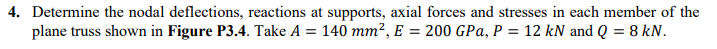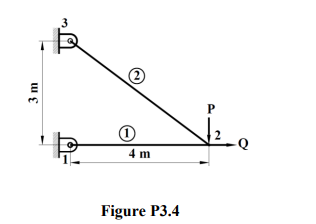

In [178]:
#QUESTION:4
n_nodes = 3
area = [140e-06,140e-06]
modulus_elasticity = [200e09, 200e09]
material_stiffness = [None, None]
theta = [0, 143.13]
length = [4, 5]
elements = 2
element_connection = {1:[1,2], 2:[2,3]}
load_status = {2:[8000,-12000]}
node_status = {1:[0,0], 2:[1,1], 3:[0,0]}

In [179]:
local_stiffness, global_stiffness, load_vector, displacement_result, reaction_result,axial_stresses = solve_truss(n_nodes,elements, theta, modulus_elasticity, length, area, material_stiffness, load_status,node_status, element_connection)

theta: 0
Cosine: 1.0
Sine: 0.0
Stiffness Factor: 6999999.999999999
theta: 143.13
Cosine: -0.8
Sine: 0.6
Stiffness Factor: 5599999.999999999


In [180]:
assignment_answers()


[[ 7000000.        0. -7000000.       -0.]
 [       0.        0.       -0.       -0.]
 [-7000000.       -0.  7000000.        0.]
 [      -0.       -0.        0.        0.]]
[[ 3584000. -2688000. -3584000.  2688000.]
 [-2688000.  2016000.  2688000. -2016000.]
 [-3584000.  2688000.  3584000. -2688000.]
 [ 2688000. -2016000. -2688000.  2016000.]]
Displacement Result
[[ 0.        ]
 [ 0.        ]
 [-0.00114286]
 [-0.00747619]
 [ 0.        ]
 [ 0.        ]]
Reaction Result
[8000.0, 0.0, -16000.0, 12000.0]
Global Stiffness
[[ 7000000.        0. -7000000.        0.        0.        0.]
 [       0.        0.        0.        0.        0.        0.]
 [-7000000.        0. 10584000. -2688000. -3584000.  2688000.]
 [       0.        0. -2688000.  2016000.  2688000. -2016000.]
 [       0.        0. -3584000.  2688000.  3584000. -2688000.]
 [       0.        0.  2688000. -2016000. -2688000.  2016000.]]
Load Vector
[[     0.]
 [     0.]
 [  8000.]
 [-12000.]
 [     0.]
 [     0.]]
Axial Stresses
[arr

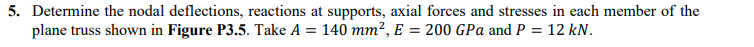
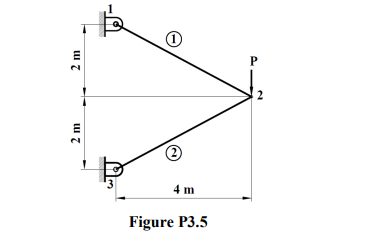

In [10]:
#QUESTION:5
n_nodes = 3
area = [140e-06,140e-06]
modulus_elasticity = [200e09, 200e09]
material_stiffness = [None, None]
theta = [-26.565, 206.565]
length = [4.472, 4.472]
elements = 2
element_connection = {1:[1,2], 2:[2,3]}
load_status = {2:[0,-12000]}
node_status = {1:[0,0], 2:[1,1], 3:[0,0]}

In [11]:
local_stiffness, global_stiffness, load_vector, displacement_result, reaction_result,axial_stresses = solve_truss(n_nodes,elements, theta, modulus_elasticity, length, area, material_stiffness, load_status, node_status, element_connection)

theta: -26.565
Cosine: 0.89
Sine: -0.45
Stiffness Factor: 6261180.67978533
theta: 206.565
Cosine: -0.89
Sine: -0.45
Stiffness Factor: 6261180.67978533


In [12]:
assignment_answers()

[[ 4959481.21645796 -2507602.86225402 -4959481.21645796  2507602.86225402]
 [-2507602.86225402  1267889.08765653  2507602.86225402 -1267889.08765653]
 [-4959481.21645796  2507602.86225402  4959481.21645796 -2507602.86225402]
 [ 2507602.86225402 -1267889.08765653 -2507602.86225402  1267889.08765653]]
[[ 4959481.21645796  2507602.86225402 -4959481.21645796 -2507602.86225402]
 [ 2507602.86225402  1267889.08765653 -2507602.86225402 -1267889.08765653]
 [-4959481.21645796 -2507602.86225402  4959481.21645796  2507602.86225402]
 [-2507602.86225402 -1267889.08765653  2507602.86225402  1267889.08765653]]
Displacement Result
[[ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [-0.00473228]
 [ 0.        ]
 [ 0.        ]]
Reaction Result
[-11866.67, 6000.0, 11866.67, 6000.0]
Global Stiffness
[[ 4959481.21645796 -2507602.86225402 -4959481.21645796  2507602.86225402
         0.                0.        ]
 [-2507602.86225402  1267889.08765653  2507602.86225402 -1267889.08765653
         0.                0.

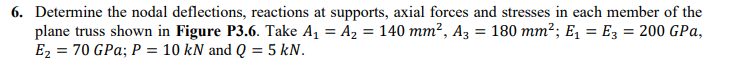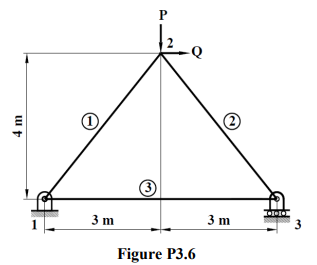

In [194]:
#QUESTION:6
n_nodes = 3
area = [140e-06,140e-06, 180e-06]
modulus_elasticity = [200e09, 70e09, 200e09]
material_stiffness = [None, None, None]
theta = [53.13, -53.13010235416, 0]
length = [5, 5, 6]
elements = 3
element_connection = {1:[1,2], 2:[2,3], 3:[1,3]}
load_status = {2:[5000,-10000]}
node_status = {1:[0,0], 2:[1,1], 3:[1,0]}

In [195]:
local_stiffness, global_stiffness, load_vector, displacement_result, reaction_result,axial_stresses = solve_truss(n_nodes,elements, theta, modulus_elasticity, length, area, material_stiffness, load_status, node_status, element_connection)

theta: 53.13
Cosine: 0.6
Sine: 0.8
Stiffness Factor: 5599999.999999999
theta: -53.13010235416
Cosine: 0.6
Sine: -0.8
Stiffness Factor: 1960000.0
theta: 0
Cosine: 1.0
Sine: 0.0
Stiffness Factor: 6000000.0


In [196]:
assignment_answers()

[[ 2016000.  2688000. -2016000. -2688000.]
 [ 2688000.  3584000. -2688000. -3584000.]
 [-2016000. -2688000.  2016000.  2688000.]
 [-2688000. -3584000.  2688000.  3584000.]]
[[  705600.  -940800.  -705600.   940800.]
 [ -940800.  1254400.   940800. -1254400.]
 [ -705600.   940800.   705600.  -940800.]
 [  940800. -1254400.  -940800.  1254400.]]
[[ 6000000.        0. -6000000.       -0.]
 [       0.        0.       -0.       -0.]
 [-6000000.       -0.  6000000.        0.]
 [      -0.       -0.        0.        0.]]
Displacement Result
[[ 0.        ]
 [ 0.        ]
 [ 0.00463967]
 [-0.00394478]
 [ 0.00104167]
 [ 0.        ]]
Reaction Result
[-5000.0, 1666.67, 8333.33]
Global Stiffness
[[ 8016000.  2688000. -2016000. -2688000. -6000000.        0.]
 [ 2688000.  3584000. -2688000. -3584000.        0.        0.]
 [-2016000. -2688000.  2721600.  1747200.  -705600.   940800.]
 [-2688000. -3584000.  1747200.  4838400.   940800. -1254400.]
 [-6000000.        0.  -705600.   940800.  6705600.  -940

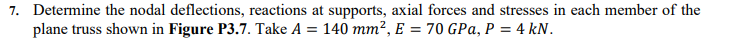
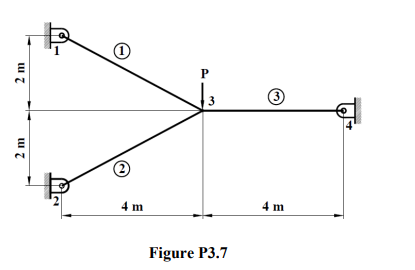

In [197]:
#QUESTION:7
n_nodes = 4
area = [140e-06,140e-06, 140e-06]
modulus_elasticity = [70e09, 70e09, 70e09]
material_stiffness = [None, None, None]
theta = [-26.57, 26.57, 0]
length = [4.472, 4.472, 4]
elements = 3
element_connection = {1:[1,3], 2:[2,3], 3:[3,4]}
load_status = {3:[0,-4000]}
node_status = {1:[0,0], 2:[0,0], 3:[1,1], 4:[0,0]}

In [198]:
local_stiffness, global_stiffness, load_vector, displacement_result, reaction_result,axial_stresses = solve_truss(n_nodes,elements, theta, modulus_elasticity, length, area, material_stiffness, load_status, node_status, element_connection)

theta: -26.57
Cosine: 0.89
Sine: -0.45
Stiffness Factor: 2191413.2379248654
theta: 26.57
Cosine: 0.89
Sine: 0.45
Stiffness Factor: 2191413.2379248654
theta: 0
Cosine: 1.0
Sine: 0.0
Stiffness Factor: 2450000.0


In [199]:
assignment_answers()

[[ 1735818.42576029  -877661.00178891 -1735818.42576029   877661.00178891]
 [ -877661.00178891   443761.18067979   877661.00178891  -443761.18067979]
 [-1735818.42576029   877661.00178891  1735818.42576029  -877661.00178891]
 [  877661.00178891  -443761.18067979  -877661.00178891   443761.18067979]]
[[ 1735818.42576029   877661.00178891 -1735818.42576029  -877661.00178891]
 [  877661.00178891   443761.18067979  -877661.00178891  -443761.18067979]
 [-1735818.42576029  -877661.00178891  1735818.42576029   877661.00178891]
 [ -877661.00178891  -443761.18067979   877661.00178891   443761.18067979]]
[[ 2450000.        0. -2450000.       -0.]
 [       0.        0.       -0.       -0.]
 [-2450000.       -0.  2450000.        0.]
 [      -0.       -0.        0.        0.]]
Displacement Result
[[ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [-0.00450693]
 [ 0.        ]
 [ 0.        ]]
Reaction Result
[-3955.56, 2000.0, 3955.56, 2000.0, 0.0, 0.0]
Global Stiffness
[[ 17

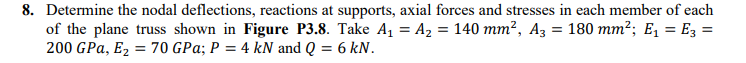
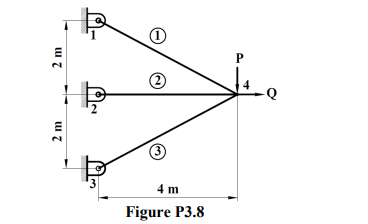

In [13]:
#QUESTION:8
n_nodes = 4
area = [140e-06,140e-06, 180e-06]
modulus_elasticity = [200e09, 70e09, 200e09]
material_stiffness = [None, None, None]
theta = [-26.565, 180, 26.565]
length = [4.472, 4, 4.472]
elements = 3
element_connection = {1:[1,4], 2:[2,4], 3:[3,4]}
load_status = {4:[6000,-4000]}
node_status = {1:[0,0], 2:[0,0], 3:[0,0], 4:[1,1]}

In [14]:
local_stiffness, global_stiffness, load_vector, displacement_result, reaction_result,axial_stresses = solve_truss(n_nodes,elements, theta, modulus_elasticity, length, area, material_stiffness, load_status,node_status, element_connection)

theta: -26.565
Cosine: 0.89
Sine: -0.45
Stiffness Factor: 6261180.67978533
theta: 180
Cosine: -1.0
Sine: 0.0
Stiffness Factor: 2450000.0
theta: 26.565
Cosine: 0.89
Sine: 0.45
Stiffness Factor: 8050089.445438282


In [15]:
assignment_answers()

[[ 4959481.21645796 -2507602.86225402 -4959481.21645796  2507602.86225402]
 [-2507602.86225402  1267889.08765653  2507602.86225402 -1267889.08765653]
 [-4959481.21645796  2507602.86225402  4959481.21645796 -2507602.86225402]
 [ 2507602.86225402 -1267889.08765653 -2507602.86225402  1267889.08765653]]
[[ 2450000.       -0. -2450000.        0.]
 [      -0.        0.        0.       -0.]
 [-2450000.        0.  2450000.       -0.]
 [       0.       -0.       -0.        0.]]
[[ 6376475.84973166  3224060.82289803 -6376475.84973166 -3224060.82289803]
 [ 3224060.82289803  1630143.11270125 -3224060.82289803 -1630143.11270125]
 [-6376475.84973166 -3224060.82289803  6376475.84973166  3224060.82289803]
 [-3224060.82289803 -1630143.11270125  3224060.82289803  1630143.11270125]]
Displacement Result
[[ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.00051356]
 [-0.00150721]]
Reaction Result
[-6326.45, 3198.77, -1258.21, 0.0, 1584.66, 801.23]
Global Stiffness

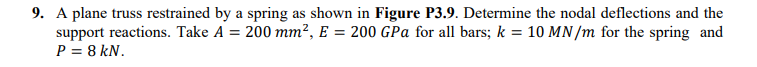
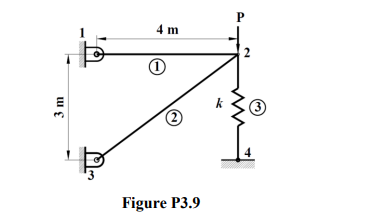

In [16]:
#QUESTION:9
n_nodes = 4
area = [200e-06, 200e-06, None]
modulus_elasticity = [200e09, 70e09, None]
material_stiffness = [None, None, 10e06]
theta = [0, -126.87, -90]
length = [4, 5, None]
elements = 3
element_connection = {1:[1,2], 2:[2,3], 3:[2,4]}
load_status = {2:[0,-8000]}
node_status = {1:[0,0], 2:[1,1], 3:[0,0], 4:[0,0]}

In [17]:
local_stiffness, global_stiffness, load_vector, displacement_result, reaction_result,axial_stresses = solve_truss(n_nodes,elements, theta, modulus_elasticity, length, area, material_stiffness, load_status,node_status, element_connection)

theta: 0
Cosine: 1.0
Sine: 0.0
Stiffness Factor: 10000000.0
theta: -126.87
Cosine: -0.6
Sine: -0.8
Stiffness Factor: 2800000.0
theta: -90
Cosine: 0.0
Sine: -1.0
Stiffness Factor: 10000000.0


In [18]:
assignment_answers()

[[ 10000000.         0. -10000000.        -0.]
 [        0.         0.        -0.        -0.]
 [-10000000.        -0.  10000000.         0.]
 [       -0.        -0.         0.         0.]]
[[ 1008000.  1344000. -1008000. -1344000.]
 [ 1344000.  1792000. -1344000. -1792000.]
 [-1008000. -1344000.  1008000.  1344000.]
 [-1344000. -1792000.  1344000.  1792000.]]
[[        0.        -0.        -0.         0.]
 [       -0.  10000000.         0. -10000000.]
 [       -0.         0.         0.        -0.]
 [        0. -10000000.        -0.  10000000.]]
Displacement Result
[[ 0.00e+00]
 [ 0.00e+00]
 [ 8.40e-05]
 [-6.88e-04]
 [ 0.00e+00]
 [ 0.00e+00]
 [ 0.00e+00]
 [ 0.00e+00]]
Reaction Result
[-840.0, 0.0, 840.0, 1120.0, 0.0, 6880.0]
Global Stiffness
[[ 10000000.         0. -10000000.         0.         0.         0.
          0.         0.]
 [        0.         0.         0.         0.         0.         0.
          0.         0.]
 [-10000000.         0.  11008000.   1344000.  -1008000.  -1344

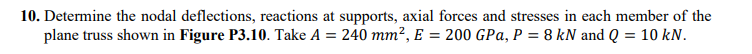
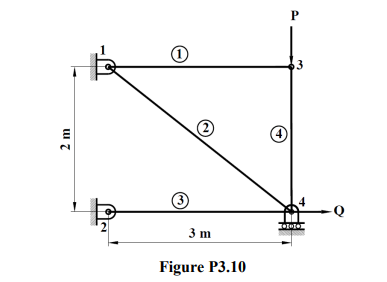

In [19]:
#QUESTION:10
n_nodes = 4
area = [240e-06,240e-06, 240e-06, 240e-06]
modulus_elasticity = [200e09, 200e09, 200e09, 200e09]
material_stiffness = [None, None, None, None]
theta = [0, -33.69, 0, -90]
length = [3, 3.61, 3, 2]
elements = 4
element_connection = {1:[1,3], 2:[1,4], 3:[2,4], 4:[3,4]}
load_status = {3:[0,-8000], 4:[10000,0]}
node_status = {1:[0,0], 2:[0,0], 3:[1,1], 4:[1,0]}

In [20]:
local_stiffness, global_stiffness, load_vector, displacement_result, reaction_result,axial_stresses = solve_truss(n_nodes,elements, theta, modulus_elasticity, length, area, material_stiffness, load_status, node_status, element_connection)

theta: 0
Cosine: 1.0
Sine: 0.0
Stiffness Factor: 16000000.0
theta: -33.69
Cosine: 0.83
Sine: -0.55
Stiffness Factor: 13296398.89196676
theta: 0
Cosine: 1.0
Sine: 0.0
Stiffness Factor: 16000000.0
theta: -90
Cosine: 0.0
Sine: -1.0
Stiffness Factor: 24000000.0


In [12]:
assignment_answers()

[[ 16000000.         0. -16000000.        -0.]
 [        0.         0.        -0.        -0.]
 [-16000000.        -0.  16000000.         0.]
 [       -0.        -0.         0.         0.]]
[[ 9159889.1966759  -6069806.09418283 -9159889.1966759   6069806.09418283]
 [-6069806.09418283  4022160.66481995  6069806.09418283 -4022160.66481995]
 [-9159889.1966759   6069806.09418283  9159889.1966759  -6069806.09418283]
 [ 6069806.09418283 -4022160.66481995 -6069806.09418283  4022160.66481995]]
[[ 16000000.         0. -16000000.        -0.]
 [        0.         0.        -0.        -0.]
 [-16000000.        -0.  16000000.         0.]
 [       -0.        -0.         0.         0.]]
[[        0.        -0.        -0.         0.]
 [       -0.  24000000.         0. -24000000.]
 [       -0.         0.         0.        -0.]
 [        0. -24000000.        -0.  24000000.]]
Displacement Result
[[ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [-0.00033333]
 [ 0.00039746]
 [ 0.  

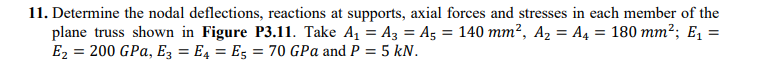
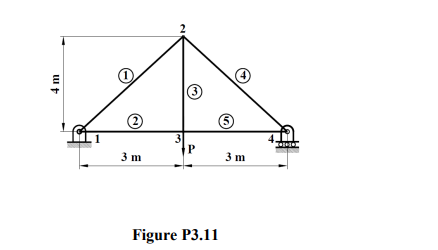

In [3]:
#QUESTION:11
n_nodes = 4
area = [140e-06, 180e-06, 140e-06, 180e-06, 140e-06]
modulus_elasticity = [200e09, 200e09, 70e09, 70e09, 70e09]
material_stiffness = [None, None, None, None, None, None]
theta = [53.13, 0, -90, -53.13, 0]
length = [5, 3, 4, 5, 3]
elements = 5
element_connection = {1:[1,2], 2:[1,3], 3:[2,3], 4:[2,4],5:[3,4]}
load_status = {3:[0,-5000]}
node_status = {1:[0,0], 2:[1,1], 3:[1,1], 4:[1,0]}

In [4]:
local_stiffness, global_stiffness, load_vector, displacement_result, reaction_result,axial_stresses = solve_truss(n_nodes,elements, theta, modulus_elasticity, length, area, material_stiffness, load_status, node_status, element_connection)

theta: 53.13
Cosine: 0.6
Sine: 0.8
Stiffness Factor: 5599999.999999999
theta: 0
Cosine: 1.0
Sine: 0.0
Stiffness Factor: 12000000.0
theta: -90
Cosine: 0.0
Sine: -1.0
Stiffness Factor: 2450000.0
theta: -53.13
Cosine: 0.6
Sine: -0.8
Stiffness Factor: 2520000.0
theta: 0
Cosine: 1.0
Sine: 0.0
Stiffness Factor: 3266666.6666666665


In [5]:
assignment_answers()

[[ 2016000.  2688000. -2016000. -2688000.]
 [ 2688000.  3584000. -2688000. -3584000.]
 [-2016000. -2688000.  2016000.  2688000.]
 [-2688000. -3584000.  2688000.  3584000.]]
[[ 12000000.         0. -12000000.        -0.]
 [        0.         0.        -0.        -0.]
 [-12000000.        -0.  12000000.         0.]
 [       -0.        -0.         0.         0.]]
[[       0.       -0.       -0.        0.]
 [      -0.  2450000.        0. -2450000.]
 [      -0.        0.        0.       -0.]
 [       0. -2450000.       -0.  2450000.]]
[[  907200. -1209600.  -907200.  1209600.]
 [-1209600.  1612800.  1209600. -1612800.]
 [ -907200.  1209600.   907200. -1209600.]
 [ 1209600. -1612800. -1209600.  1612800.]]
[[ 3266666.66666667        0.         -3266666.66666667       -0.        ]
 [       0.                0.               -0.               -0.        ]
 [-3266666.66666667       -0.          3266666.66666667        0.        ]
 [      -0.               -0.                0.                0.  

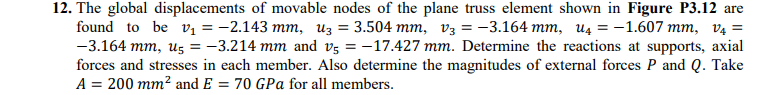
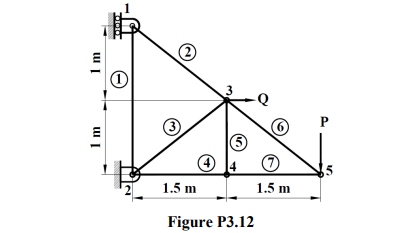

In [6]:
#QUESTION:12
n_nodes = 5
area = [200e-06, 200e-06, 200e-06, 200e-06, 200e-06, 200e-06, 200e-06]
modulus_elasticity = [70e09, 70e09, 70e09, 70e09, 70e09, 70e09, 70e09]
material_stiffness = [None, None, None, None, None, None, None]
theta = [-90, -33.69, 33.69, 0, -90, -33.69, 0]
length = [2, 1.80, 1.80, 1.5, 1, 1.80, 1.5]
elements = 7
element_connection = {1:[1,2], 2:[1,3], 3:[2,3], 4:[2,4], 5:[3,4], 6:[3,5], 7:[4,5]}
load_status = {3:[0, None], 5:[None,0]}
node_status = {1:[0,1], 2:[0,0], 3:[1,1], 4:[1,1], 5:[1,1]}
displacement = np.array([0, -2.143e-03, 0, 0, 3.504e-03, -3.164e-03, -1.607e-03, -3.164e-03, -3.214e-03, -17.427e-03])

In [9]:
stiffness, global_stiffness, reaction_forces, external_forces, axial_stresses,load_vector = solve_inverse(n_nodes, area, modulus_elasticity, material_stiffness, theta, length, elements, element_connection, load_status, node_status, displacement)

theta: -90
Cosine: 0.0
Sine: -1.0
Stiffness Factor: 7000000.0
theta: -33.69
Cosine: 0.83
Sine: -0.55
Stiffness Factor: 7777777.777777778
theta: 33.69
Cosine: 0.83
Sine: 0.55
Stiffness Factor: 7777777.777777778
theta: 0
Cosine: 1.0
Sine: 0.0
Stiffness Factor: 9333333.333333334
theta: -90
Cosine: 0.0
Sine: -1.0
Stiffness Factor: 14000000.0
theta: -33.69
Cosine: 0.83
Sine: -0.55
Stiffness Factor: 7777777.777777778
theta: 0
Cosine: 1.0
Sine: 0.0
Stiffness Factor: 9333333.333333334


In [11]:
for stiff in stiffness:
    print(stiff)
print('External Forces')
print(external_forces)
print('Reaction Result')
print(reaction_forces)
print('Global Stiffness')
print(global_stiffness)
print('Axial Stresses')
print(axial_stresses)
print('load_vector')
print(load_vector)

[[       0.       -0.       -0.        0.]
 [      -0.  7000000.        0. -7000000.]
 [      -0.        0.        0.       -0.]
 [       0. -7000000.       -0.  7000000.]]
[[ 5358111.11111111 -3550555.55555556 -5358111.11111111  3550555.55555556]
 [-3550555.55555556  2352777.77777778  3550555.55555556 -2352777.77777778]
 [-5358111.11111111  3550555.55555556  5358111.11111111 -3550555.55555556]
 [ 3550555.55555556 -2352777.77777778 -3550555.55555556  2352777.77777778]]
[[ 5358111.11111111  3550555.55555556 -5358111.11111111 -3550555.55555556]
 [ 3550555.55555556  2352777.77777778 -3550555.55555556 -2352777.77777778]
 [-5358111.11111111 -3550555.55555556  5358111.11111111  3550555.55555556]
 [-3550555.55555556 -2352777.77777778  3550555.55555556  2352777.77777778]]
[[ 9333333.33333333        0.         -9333333.33333333       -0.        ]
 [       0.                0.               -0.               -0.        ]
 [-9333333.33333333       -0.          9333333.33333333        0.        ]


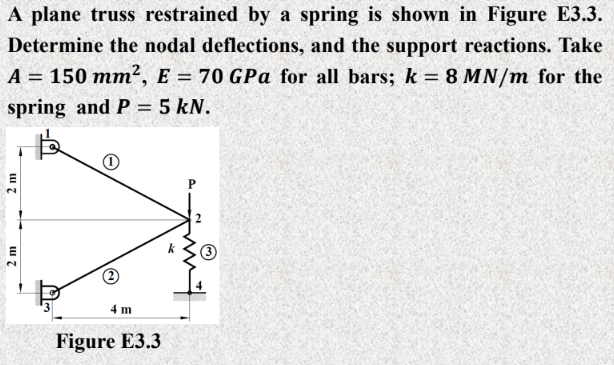

In [20]:
#Example3.3
n_nodes = 4
area = [150e-06, 150e-06, None]
modulus_elasticity = [70e09, 70e09, None]
material_stiffness = [None, None, 8e06]
theta = [-26.565, 206.565, -90]
length = [4.472, 4.472, None]
elements = 3
element_connection = {1:[1,2], 2:[2,3], 3:[2,4]}
load_status = {2:[0,-5000]}
node_status = {1:[0,0], 2:[1,1], 3:[0,0], 4:[0,0]}

In [21]:
local_stiffness, global_stiffness, load_vector, displacement_result, reaction_result,axial_stresses = solve_truss(n_nodes,elements, theta, modulus_elasticity, length, area, material_stiffness, load_status, node_status, element_connection)

theta: -26.565
Cosine: 0.89
Sine: -0.45
Stiffness Factor: 2347942.7549194987
theta: 206.565
Cosine: -0.89
Sine: -0.45
Stiffness Factor: 2347942.7549194987
theta: -90
Cosine: 0.0
Sine: -1.0
Stiffness Factor: 8000000.0


In [22]:
assignment_answers()

[[ 1859805.45617173  -940351.07334526 -1859805.45617173   940351.07334526]
 [ -940351.07334526   475458.4078712    940351.07334526  -475458.4078712 ]
 [-1859805.45617173   940351.07334526  1859805.45617173  -940351.07334526]
 [  940351.07334526  -475458.4078712   -940351.07334526   475458.4078712 ]]
[[ 1859805.45617173   940351.07334526 -1859805.45617173  -940351.07334526]
 [  940351.07334526   475458.4078712   -940351.07334526  -475458.4078712 ]
 [-1859805.45617173  -940351.07334526  1859805.45617173   940351.07334526]
 [ -940351.07334526  -475458.4078712    940351.07334526   475458.4078712 ]]
[[       0.       -0.       -0.        0.]
 [      -0.  8000000.        0. -8000000.]
 [      -0.        0.        0.       -0.]
 [       0. -8000000.       -0.  8000000.]]
Displacement Result
[[ 0.       ]
 [ 0.       ]
 [ 0.       ]
 [-0.0005586]
 [ 0.       ]
 [ 0.       ]
 [ 0.       ]
 [ 0.       ]]
Reaction Result
[-525.28, 265.59, 525.28, 265.59, 0.0, 4468.82]
Global Stiffness
[[ 1859805.

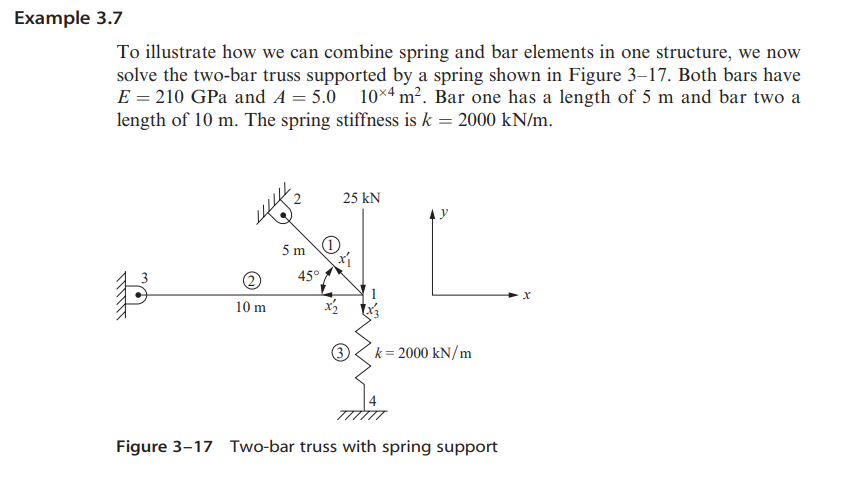

In [12]:
n_nodes = 4
area = [5e-04,5e-04,None]
modulus_elasticity = [210e09, 210e09,None]
material_stiffness = [None, None, 2000e03]
theta = [135, 180, 90]
length = [5, 10, None]
elements = 3
element_connection = {1:[1,2], 2:[1,3], 3:[1,4]}
load_status = {1:[0,-25000]}
node_status = {1:[1,1], 2:[0,0], 3:[0,0], 4:[0,0]}

In [13]:
global_stiffness, load_vector, displacement_result, reaction_result = solve_truss(n_nodes,elements, theta, modulus_elasticity, length, area, material_stiffness, load_status,node_status)

In [14]:
displacement_result

array([[-0.00172607],
       [-0.00343811],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ]])

In [30]:
axial_stresses = axial_stress(elements, element_connection, modulus_elasticity, length, displacement_result, theta)

In [ ]:
def get_input():
    #Ask for the number of nodes
    n_nodes = int(input("Enter the number of nodes: "))
    # Ask for the number of elements
    elements = int(input("Enter the number of elements: "))

    # Initialize lists for area, modulus of elasticity, theta, length, and material stiffness
    area = []
    modulus_elasticity = []
    theta = []
    length = []
    material_stiffness = []

    # Get data for each element
    for i in range(elements):
        print(f"\nEnter details for element {i+1}:")

        # Ask for modulus of elasticity, area, length, or material stiffness
        area_input = input(f"  Enter area for element {i+1} (e.g., 20, or press Enter to skip): ")
        if area_input.strip():
            area.append(float(area_input))
        else:
            area.append(None)

        modulus_input = input(f"  Enter modulus of elasticity for element {i+1} (e.g., 200, or press Enter to skip): ")
        if modulus_input.strip():
            modulus_elasticity.append(float(modulus_input))
        else:
            modulus_elasticity.append(None)

        length_input = input(f"  Enter length for element {i+1} (e.g., 2, or press Enter to skip): ")
        if length_input.strip():
            length.append(float(length_input))
        else:
            length.append(None)

        # Ask for material stiffness directly (optional)
        stiffness_input = input(f"  Enter material stiffness for element {i+1} (e.g., 10000, or press Enter to skip): ")
        if stiffness_input.strip():
            material_stiffness.append(float(stiffness_input))
        else:
            material_stiffness.append(None)

        # Ask for angle (theta)
        t = input(f"  Enter angle (theta) for element {i+1} (in degrees, e.g., 0, -90, 135): ")
        if t.strip():
            theta.append(float(t))
        else:
            theta.append(None)

    # Get node connectivity
    element_connection = {}
    print("\nEnter node connectivity between elements:")
    for i in range(1, elements + 1):
        conn = input(f"  Enter nodes connected by element {i} (e.g., 1,2 for element 1): ").split(',')
        element_connection[i] = [int(x) for x in conn]

    # Get load status
    load_status = {}
    print("\nEnter load status (for nodes with applied loads):")
    load_nodes = input("  Enter node IDs with applied loads (comma separated, e.g., 1, 2, 3): ").split(',')
    load_nodes = [int(x.strip()) for x in load_nodes]
    
    for node_id in load_nodes:
        load_x = float(input(f"    Enter load in x-direction for node {node_id}: "))
        load_y = float(input(f"    Enter load in y-direction for node {node_id}: "))
        load_status[node_id] = [load_x, load_y]

    # Get node status (displacements)
    node_status = {}
    print("\nEnter node displacement status (0 = fixed, 1 = flexible) for each node:")
    for i in range(n_nodes):
        displacement_x = int(input(f"  Enter displacement status in x-direction for node {i+1} (0 = fixed, 1 = flexible): "))
        displacement_y = int(input(f"  Enter displacement status in y-direction for node {i+1} (0 = fixed, 1 = flexible): "))
        node_status[i+1] = [displacement_x, displacement_y]
    
    return n_nodes, area, modulus_elasticity, theta, length, material_stiffness, elements, element_connection, load_status, node_status

# Call the function and store the inputs
n_nodes, area, modulus_elasticity, theta, length, material_stiffness, elements, element_connection, load_status, node_status = get_input()

# Print the collected data to check if everything looks correct
print("\nCollected Input Data:")
print("Area: ", area)
print("Modulus of Elasticity: ", modulus_elasticity)
print("Theta: ", theta)
print("Length: ", length)
print("Material Stiffness: ", material_stiffness)
print("Element Connection: ", element_connection)
print("Load Status: ", load_status)
print("Node Status: ", node_status)


In [ ]:
print("\nCollected Input Data:")
print("Area: ", area)
print("Modulus of Elasticity: ", modulus_elasticity)
print("Theta: ", theta)
print("Length: ", length)
print("Material Stiffness: ", material_stiffness)
print("Element Connection: ", element_connection)
print("Load Status: ", load_status)
print("Node Status: ", node_status)

In [152]:
# def vectors_inverse_2D(n_nodes, node_status, load_status):
#     fixed_node_pos = []
#     flexible_node_pos = []
#     load_node_pos= []
#     for node,status in node_status.items():
#         i = node*2-2
#         if(not status[0]):
#             fixed_node_pos.append(i)
#         else:
#             flexible_node_pos.append(i)
#         if(not status[1]):
#             fixed_node_pos.append(i+1)
#         else:
#             flexible_node_pos.append(i+1)
#     for node, load in load_status.items():
#         i = node*2-2
#         if (load[0] is not None):
#             load_node_pos.append(i)
#         if (load[1] is not None):
#             load_node_pos.append(i+1)
        
    
#     return [fixed_node_pos, flexible_node_pos, load_node_pos]

# def solve_inverse(n_nodes, area, modulus_elasticity, material_stiffness, theta, length, elements, element_connection, load_status, node_status, displacement):
#     stiffness = []
#     for element in range(elements):
#         stiffness.append(element_stiffness_2D(theta[element],modulus_elasticity= modulus_elasticity[element], length = length[element], area = area[element], material_stiffness=material_stiffness[element]))

#     global_stiffness = global_stiffness_matrix_2D(stiffness, n_nodes, element_connection )
#     # print(global_stiffness)
#     fixed_node_pos, flexible_node_pos, load_node_pos = vectors_inverse_2D(n_nodes, node_status, load_status)
#     reaction_forces = reaction_force(global_stiffness,displacement,fixed_node_pos)
#     external_forces = reaction_force(global_stiffness,displacement,load_node_pos)
#     axial_stresses = axial_stress(elements, element_connection, modulus_elasticity, length, displacement, theta)
    
#     return [stiffness, global_stiffness, reaction_forces, external_forces, axial_stresses]
    
    
# def solve_truss(n_nodes,elements, theta, modulus_elasticity, length, area, material_stiffness, load_status, node_status, element_connection):
#     stiffness = []
#     for element in range(elements):
#         stiffness.append(element_stiffness_2D(theta[element],modulus_elasticity= modulus_elasticity[element], length = length[element], area = area[element], material_stiffness=material_stiffness[element]))

#     global_stiffness = global_stiffness_matrix_2D(stiffness, n_nodes, element_connection )
#     # print(global_stiffness)
#     fixed_node, flexible_node, load_vec = vectors_2D(n_nodes, node_status, load_status)
#     # print(fixed_node)
#     # print(load_vec)
#     stiff = sub_matrix(global_stiffness, flexible_node)
#     load_vec_small = load_vec[flexible_node]
#     disp_vector = np.zeros((n_nodes*2,1), dtype='float')
#     disp_vector[flexible_node] = displacement(stiff, load_vec_small)
#     reaction_forces = reaction_force(global_stiffness,disp_vector,fixed_node)
#     axial_stresses = axial_stress(elements, element_connection, modulus_elasticity, length, disp_vector, theta)
#     return [stiffness, global_stiffness, load_vec, disp_vector, reaction_forces, axial_stresses]